In [1]:
import time
import sys

from graph_nets import blocks
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
from matplotlib import pyplot as plt
from simulate_orbits import *
import numpy as np
from copy import deepcopy

import random as rand

import graph_nets as gn
import sonnet as snt
import tensorflow as tf
import networkx as nx

# For debugging only
#tf.compat.v1.enable_eager_execution()

In [2]:
def get_orbital_velocity(radius, mass_planet, mass_star, G, ellipcity_noise = 0):
    """Calculate the velocity required to keep an orbit

    Parameters
    ---------- 
    radius : float
      the radial distance from the body to the center of the orbit
    mass_planet : float
      mass of the planet orbiting
    mass_star : float
      mass of the body at the center of the orbit
    G : float 
      Gravitational Constant
    noise: float
      The maximum fractional amount by which the initial velocity is perturbed. 
      Defaults to zero

    Returns
    ---------- 
    velocity : float
      the orbital velocity

    """

    velocity = np.sqrt(G*mass_star/radius)

    # Add noise
    if ellipcity_noise > 0:
        delta_vel = np.random.normal(0, ellipcity_noise, size = np.shape(velocity))
        #delta_vel = rand.uniform(*(-ellipcity_noise,ellipcity_noise), size = np.shape(velocity))
        velocity *= (1.+delta_vel)

    return np.array(velocity)

def get_trajectory(planets, num_time_steps):
    '''
    Calculate real trajectory using Euler integration
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    num_time_steps : float
        The number of integration steps    
      
    Returns
    -------
    x_traj, p_traj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    '''
    
    nplanets = len(planets)
    x_traj = np.zeros([num_time_steps, nplanets, 2])
    p_traj = np.zeros([num_time_steps, nplanets, 2])
    for i in range(num_time_steps):
        pos = []
        mom = []
        for planet in planets:
            pos.append(planet.orbit[i][0:2])
            mom.append(planet.orbit[i][3:5]*planet.mass)
        
        x_traj[i] = np.array(pos) #km
        p_traj[i] = np.array(mom)#km/s

    return x_traj, p_traj

In [3]:
def get_input_graph(planets, xtraj, t, noise_level = 0.0):
    '''
    Convert a given time into a GraphNets graph that can be used to train a model
    
    Parameters
    ----------
    planets : ls
        A list of planets using the Body class
    xtraj: np.array([num_time_steps, nplanets, 2])
        The positions and momenta of the trajectory for each planet
    t: int
        The time at which the trajectory is evaluated
    noise_level: float
        Fractional noise added to the training, defaults to 0.05
        
    Returns
    -------
    graph_dict: dict
        A dictionary containing globals, edges, nodes, senders and receivers
    '''
    nplanets = len(planets)
    nodes, edges, senders, receivers = [], [], [], []
    for i in range(nplanets):
        noise_mass = np.random.normal(0, noise_level)
        mass = planets[i].mass#*(1+noise_mass)
        nodes.append([mass]) #Use Mercury's mass for units to normalize
        for j in range(nplanets):
            # I do this instead of if i != j, so the distances and forces are not duplicate, this
            # improves the model. I am basically telling the model that F(ij)=F(ji)
            if i > j:
                d = xtraj[t,j,:] - xtraj[t,i,:]
                if noise_level > 0:
                    noise_dist = tf.random.normal([2], 0, noise_level, tf.float32) 
                    edges.append(d*(1+noise_dist))
                else:
                    edges.append(d)
 
                receivers.append(i)
                senders.append(j)
    
    return{
      "globals": [G],
      "nodes": nodes,
      "edges": edges, 
      "receivers": receivers, 
      "senders": senders 
    }  

## Integration Functions

In [4]:
def generate_random_planets(mstar_lims = [0.9, 1.1], 
                            mplanet_lims = [0.4, 0.6],
                            rplanet_lims = [0.4, 0.6],
                            nplanets=1,
                           ellipcity_noise = 0.):
 
    star = Body()
    star.name = 'star'
    #star.mass = np.random.uniform(mstar_lims[0], mstar_lims[1])*MSUN/MEARTH # solar masses
    star.mass = MSUN/MEARTH
    
    planets = [star]
    total_mom = np.zeros(3)
    total_cm = np.zeros(3)
    
    for i in range(nplanets):
        planet = Body()
        planet.name = 'planet_' + str(i)
        planet.mass = np.random.uniform(mplanet_lims[0], mplanet_lims[1])*1e24/MEARTH # Earth masses
        #planet.mass = mercury.mass
        #pos_planet = pos_mercury
        pos_planet = np.random.uniform(rplanet_lims[0], rplanet_lims[1])
        vel_planet = get_orbital_velocity(pos_planet, planet.mass, star.mass, G, ellipcity_noise)
        planet.initiate(pos_planet, vel_planet)
        planets.append(planet)
        total_mom += np.array(planet.vel)*planet.mass
        total_cm += np.array(planet.pos)*planet.mass
        
    planets[0].vel = - total_mom/star.mass
    planets[0].pos = - total_cm/star.mass
    
    return planets

In [5]:
def generate_batch(planets, total_time, delta_time, batch_size, norm_factor = 1, ellipcity_noise = 0):
    num_time_steps = int(total_time/delta_time)
    x_traj_ls = []
    p_traj_ls = []
    dp_traj_ls = []
    for i in range(batch_size):
        if isinstance(planets[0],list): # If we are using different planet lists for each batch
            planets_batch = deepcopy(planets[i])
        else:
            planets_batch = deepcopy(planets)
        
        total_mom = np.zeros(3)
        total_cm = np.zeros(3)
        for planet in planets_batch:
            if planet.name not in ['Sun', 'star']:
                pos_planet = np.linalg.norm(planet.pos)
                vel_planet = get_orbital_velocity(pos_planet, 
                                                  planet.mass, 
                                                  planets_batch[0].mass, 
                                                  G, 
                                                  ellipcity_noise)
                planet.initiate(pos_planet, vel_planet)
                total_mom += np.array(planet.vel)*planet.mass
                total_cm += np.array(planet.pos)*planet.mass
        
        planets_batch[0].vel = - total_mom/planets_batch[0].mass
        planets_batch[0].pos = - total_cm/planets_batch[0].mass
        
        simulate(planets_batch, total_time, delta_time)
        x_traj_np, p_traj_np = get_trajectory(planets_batch, int(total_time/delta_time))
        dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]
        
        x_traj_ls.append(x_traj_np)
        p_traj_ls.append(p_traj_np)
        dp_traj_ls.append(dp_traj_np/norm_factor)

    x_traj = tf.convert_to_tensor(np.asarray(x_traj_ls), dtype=np.float32)
    dp_traj = tf.convert_to_tensor(np.asarray(dp_traj_ls), dtype=np.float32)
    p_traj = tf.convert_to_tensor(np.asarray(p_traj_ls), dtype=np.float32)
        
    return x_traj, dp_traj, p_traj


In [6]:
def get_distances(x, input_graph):
    '''
    Convert positions to distances
    '''
    new_graph = input_graph.replace(nodes = x)
    e1 = blocks.broadcast_sender_nodes_to_edges(new_graph)
    e2 = blocks.broadcast_receiver_nodes_to_edges(new_graph)
    dx = e1 - e2
    return dx

def model_gn(dx, input_graph, num_processing_steps, normalization = 1):
    '''
    Use the model to go from dx to dp
    '''
    graph = input_graph.replace(edges = dx)
    outputs = model(graph, num_processing_steps)
    outputs_p = get_momentum_update(outputs)
    output = sum(outputs_p)/num_processing_steps
    dp = output*normalization

    edges = [output.edges for output in outputs]
    forces_unnorm = sum(edges)/num_processing_steps
    forces = forces_unnorm*normalization
    return dp, forces

def get_leapfrog_step(x0, ph, delta_time, input_graph, model, num_processing_steps, normalization = 1):
    
    delta_x = delta_time/input_graph.nodes
    
    x1 = x0 + ph*delta_x
    
    dx = get_distances(x0, input_graph)
    
    dp, force = model(dx, input_graph, num_processing_steps, normalization)
    ph3 = ph + dp

    return x1, ph3, dp, force

def leapfrog_integration(x0, p0, delta_time, input_graph, num_steps, model, num_processing_steps, normalization = 1):
    '''
    Learn the orbit through leapfrom integration
    '''
    def body(i, x0, p0, x_pred, dp_pred, f_pred):
        x, ph, dp, force =  get_leapfrog_step(
            x0, p0, delta_time, 
            input_graph, 
            model, 
            num_processing_steps, 
            normalization)
        return i+1, x, ph, x_pred.write(i, x), dp_pred.write(i-1, dp/normalization), f_pred.write(i-1, force)
    
    # Distance
    dx = get_distances(x0, input_graph)

    # Model predict*norm_p = F*dt
    # (ph = phalf)
    dph, fh = model(dx, input_graph, num_processing_steps, normalization)
    ph = p0 + 0.5*dph
    x = tf.identity(x0)
    
    i = 0

    x_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps, element_shape=x0.shape)
    dp_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=x0.shape)
    f_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=fh.shape)

    x_pred = x_pred.write(0, x0)
    
    _, _, _, x_pred, dp_pred, f_pred = tf.while_loop(
    lambda i, *unused_args: i < num_steps,
        body,
        loop_vars = [1, x0, ph, x_pred, dp_pred, f_pred]
    )
    return x_pred.stack(), dp_pred.stack(), f_pred.stack()

# OLD

In [7]:
def get_distances_old(x0, nplanets, as_tensor = True):
    '''
    Convert positions to distances
    '''
    dx = []
    for i in range(nplanets):
        for j in range(nplanets):
            if i > j:
                dx.append(x0[j] - x0[i])
    
    if as_tensor == True:
        dx = tf.convert_to_tensor(dx, dtype=np.float32)
    else:
        dx = np.array(dx)
        
    return dx

def model_gn_old(dx, num_processing_steps):
    '''
    Use the model to go from dx to dp
    '''
    graph = input_graph_test_old.replace(edges=dx)
    outputs = model(graph, num_processing_steps)
    outputs_p = get_momentum_update(outputs)
    output = sum(outputs_p)/num_processing_steps
    dp = output*np.std(dp_traj_np)

    edges = [output.edges for output in outputs]
    forces_unnorm = sum(edges)/num_processing_steps
    forces = forces_unnorm*np.std(dp_traj_np)
    return dp, forces

def get_leapfrog_step_old(x, ph, dt, planets, model, num_processing_steps):   #(x, ph, dt, m1, m2, model):
    '''
    Perform a step for the leapfrog integration
    '''
    dtm = []
    for planet in planets:
        dtm.append([dt/planet.mass])
    
    deltax=ph*tf.convert_to_tensor(dtm,dtype = np.float32)
    
    x1 = x+deltax

    dx = get_distances_old(x, len(planets))

    dp, force = model(dx, num_processing_steps)
    ph3 = ph + dp

    return x1, ph3, dp, force

def leapfrog_integration_old(x0, p0, planets,dt, num_steps, model, num_processing_steps):
    '''
    Learn the orbit through leapfrom integration
    '''
    def body(i, x0, p0, x_pred, dp_pred, f_pred):
        x, ph, dp, force =  get_leapfrog_step_old(x0, p0, dt, planets,model, num_processing_steps)
        return i+1, x, ph, x_pred.write(i, x), dp_pred.write(i-1, dp/np.std(dp_traj_np)), f_pred.write(i-1, force)
    
    # Distance
    dx = get_distances_old(x0, len(planets))

    # Model predict*norm_p = F*dt
    # (ph = phalf)
    dph, fh = model(dx,  num_processing_steps)
    ph = p0 + 0.5*dph
    x = tf.identity(x0)
    
    i = 0

    x_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps, element_shape=x0.shape)
    dp_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=x0.shape)
    f_pred = tf.TensorArray(
      dtype=tf.float32, size=num_steps-1, element_shape=fh.shape)

    x_pred = x_pred.write(0, x0)
    
    _, _, _, x_pred, dp_pred, f_pred = tf.while_loop(
    lambda i, *unused_args: i < num_steps,
        body,
        loop_vars = [1, x0, ph, x_pred, dp_pred, f_pred]
    )
    return x_pred.stack(), dp_pred.stack(), f_pred.stack()

In [8]:
# Global constants
DAY = 24*3600. # Day in seconds
YEAR = 365.25*DAY #Year
delta_time = (2/24.)*DAY/YEAR # 2 hours
#delta_time = 0.1*DAY/YEAR # 1 hour

total_time_test = 1
num_time_steps_test = int(total_time_test/delta_time)

total_time_tr = 200*delta_time
num_time_steps_tr = int(total_time_tr/delta_time)

batch_size_table = 50
total_time_table = 200*delta_time
num_time_steps_table = int(total_time_table/delta_time)

num_processing_steps_tr = 1
patience = 10
batch_size = 500
d_patience = 1e-4
#d_patience = 0
noise_level = 0.05

# How much time between logging and printing the current results.
log_every_iterations = 1000
num_training_iterations = 150000

sun = Body()
sun.name = 'Sun'
sun.mass = MSUN/MEARTH # solar masses
sun.pos = np.zeros(3) 

mercury = Body()
mercury.name = 'Mercury'
mercury.mass = 0.33011 * 10**24/MEARTH # Earth masses
pos_mercury = 0.387 # AU
vel_mercury = get_orbital_velocity(pos_mercury, 
                                   mercury.mass, 
                                   sun.mass, 
                                   G,
                                   ellipcity_noise = 0.01
                                  )
mercury.initiate(pos_mercury, vel_mercury)
    
venus = Body()
venus.name = 'Venus'
venus.mass = 4.8685 * 10**24/MEARTH # Earth masses
pos_venus = 0.723 # AU
vel_venus = get_orbital_velocity(pos_venus, 
                                 venus.mass, 
                                 sun.mass, 
                                 G,
                                ellipcity_noise = 0.01)
venus.initiate(pos_venus, vel_venus)

earth = Body()
earth.name = 'Earth'
earth.mass =1. # Earth masses
pos_earth = 1 # AU
vel_earth = get_orbital_velocity(pos_earth, 
                                 earth.mass, 
                                 sun.mass, 
                                 G, 
                                ellipcity_noise = 0.01)
earth.initiate(pos_earth, vel_earth)

mars = Body()
mars.name = 'Mars'
mars.mass =0.642 * 10**24/MEARTH # Earth masses
pos_mars = 1.52341740516 # AU
vel_mars = get_orbital_velocity(pos_mars, 
                                 mars.mass, 
                                 sun.mass, 
                                 G, 
                                ellipcity_noise = 0.01)
mars.initiate(pos_mars, vel_mars)


sun.vel = -(np.array(mercury.vel)*mercury.mass + 
            np.array(venus.vel)*venus.mass +
            np.array(earth.vel)*earth.mass #+
            #np.array(mars.vel)*mars.mass
            )/sun.mass

# Center at zero (improves stability)
sun.pos = -(np.array(mercury.pos)*mercury.mass + 
            np.array(venus.pos)*venus.mass +
            np.array(earth.pos)*earth.mass #+ 
            #np.array(mars.pos)*mars.mass
            )/sun.mass
#sun.pos = np.zeros(3)

planets = [sun, mercury, venus, earth]#, mars]
nplanets = len(planets)
    
planets_gn = deepcopy(planets)

simulate(planets, total_time_test, delta_time)

x_traj_np, p_traj_np = get_trajectory(planets, num_time_steps_test)
dp_traj_np = p_traj_np[1:] - p_traj_np[:-1]

dp_traj_norm = tf.convert_to_tensor(
    dp_traj_np/np.std(dp_traj_np), dtype=np.float32)

p_norm = np.std(dp_traj_np)

x_traj_test = tf.convert_to_tensor(x_traj_np, dtype=np.float32)
p_traj_test = tf.convert_to_tensor(p_traj_np, dtype=np.float32)

input_dict_test = get_input_graph(planets, x_traj_test, 0, noise_level = 0.0)

input_graph_test = utils_tf.data_dicts_to_graphs_tuple([input_dict_test])
input_graph_test_old = utils_tf.data_dicts_to_graphs_tuple([input_dict_test])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
x_traj_tr, dp_traj_tr, _ = generate_batch(
    planets_gn, total_time_tr, delta_time, batch_size, norm_factor = p_norm, ellipcity_noise = 0.03)

Text(0.5, 1.0, 'Graph')

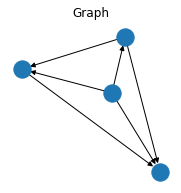

In [10]:
# Generate and visualize a Graph

data_dict = get_input_graph(planets, x_traj_test,0)
graphs_tuple = utils_np.data_dicts_to_graphs_tuple([data_dict])
graphs_nx = utils_np.graphs_tuple_to_networkxs(graphs_tuple)

ax = plt.figure(figsize=(3, 3)).gca()
nx.draw(graphs_nx[0], ax=ax)
ax.set_title("Graph")

In [11]:
graphs_tuple = utils_tf.data_dicts_to_graphs_tuple([data_dict])

In [12]:
# Get sum over all received nodes for each body

reducer = tf.unsorted_segment_sum
t1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)
t2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(graphs_tuple)

#with tf.Session() as sess:
#    print(t.eval())

#print(t1)
#print(t2)
#print(t1-t2)

In [13]:
# Create the model.
model = models.EncodeProcessDecode(node_output_size=0, edge_output_size=2, global_output_size=0)

In [14]:
def get_momentum_update(output_ops):
    reducer = tf.unsorted_segment_sum
    
    dp = []
    for output_op in output_ops:
        b1 = blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        b2 = blocks.SentEdgesToNodesAggregator(reducer=reducer)(output_op)
        dp.append(b1-b2)
    '''
    dp = [
        blocks.ReceivedEdgesToNodesAggregator(reducer=reducer)(output_op)
        for output_op in output_ops]
    '''
    return dp


def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.
    """
    loss_ops = [
        tf.reduce_mean(
            tf.reduce_sum((output_op - target_op)**2, axis=-1))
        for output_op in output_ops
    ]
    return loss_ops

In [15]:
t = tf.random_uniform([], minval=0, maxval=num_time_steps_tr - 1, dtype=tf.int32)
input_dict_tr = []
for i in range(batch_size):
    input_dict_tr.append(get_input_graph(planets, x_traj_tr[i], t, noise_level = noise_level))
    
input_graph_tr = utils_tf.data_dicts_to_graphs_tuple(input_dict_tr)
output_model = model(input_graph_tr, num_processing_steps_tr)
output_ops_tr = get_momentum_update(output_model)
target_nodes_tr = tf.reshape(dp_traj_tr[:,t], shape=[batch_size*nplanets, 2])



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [16]:
# Integration (test)
x0 = x_traj_test[0]
p0 = p_traj_test[0]
xp, pp, fp = leapfrog_integration(
    x0, p0, 
    delta_time, 
    input_graph_test, 
    num_time_steps_test, 
    model_gn, 
    num_processing_steps_tr,
    normalization = p_norm)

loss_test = tf.reduce_mean(
    tf.reduce_sum(
    (pp - dp_traj_norm)**2., axis = -1
    ))

In [17]:
'''
# Integration (old)
nsteps_int = num_time_steps_test
x0_old = x_traj_test[0]
p0_old = p_traj_test[0]
xp_old, pp_old, fp_old = leapfrog_integration_old(
    x0_old, p0_old, planets_gn, delta_time, nsteps_int, model_gn_old, num_processing_steps_tr)

loss_test_old = tf.reduce_mean(
    tf.reduce_sum(
    (pp_old - dp_traj_norm[:nsteps_int-1])**2., axis = -1
    ))
'''

'\n# Integration (old)\nnsteps_int = num_time_steps_test\nx0_old = x_traj_test[0]\np0_old = p_traj_test[0]\nxp_old, pp_old, fp_old = leapfrog_integration_old(\n    x0_old, p0_old, planets_gn, delta_time, nsteps_int, model_gn_old, num_processing_steps_tr)\n\nloss_test_old = tf.reduce_mean(\n    tf.reduce_sum(\n    (pp_old - dp_traj_norm[:nsteps_int-1])**2., axis = -1\n    ))\n'

In [18]:
planets_table = []
for i in range(batch_size_table):
    planets_table.append(generate_random_planets())

batch_size_table = 3
planets_table = [[sun,mercury],[sun,venus],[sun,earth]]
    
x_traj_table, dp_traj_table, p_traj_table = generate_batch(
    planets_table, total_time_table, delta_time, batch_size_table, 
    norm_factor = p_norm, ellipcity_noise = 0.0)

# Integration (table)
input_dict_table= []
for i in range(batch_size_table):
    input_dict_table.append(get_input_graph(planets_table[i], x_traj_table[i], 0, noise_level = 0))
    
input_graph_table = utils_tf.data_dicts_to_graphs_tuple(input_dict_table)

In [19]:
planets_flat = sum(planets_table, [])
#get_leapfrog_step(x0, p0, delta_time, input_graph_table, model_gn, num_processing_steps_tr, p_norm)
x0_table = tf.reshape(x_traj_table[:,0], shape=(len(planets_flat),2))
p0_table = tf.reshape(p_traj_table[:,0], shape=(len(planets_flat),2))
xp_table, dp_table, fp_table = leapfrog_integration(
    x0_table, p0_table, delta_time, input_graph_table, 
    num_time_steps_table, model_gn, num_processing_steps_tr, p_norm)

dp_traj_table_flat = tf.transpose(dp_traj_table, perm=[1,0,2,3])
dp_traj_table_flat = tf.reshape(dp_traj_table_flat, shape=(num_time_steps_table-1, len(planets_flat), 2))

loss_table = tf.reduce_mean(
    tf.reduce_sum(
    (dp_table - dp_traj_table_flat)**2., axis = -1
    ))

#xp_table = tf.reshape(xp_table, shape=x_traj_table.shape)
#fp_table = tf.reshape(fp_table, shape=(num_time_steps_table-1, len(input_dict_table), 2))

In [20]:
# Training loss.
loss_ops_tr = create_loss_ops(target_nodes_tr, output_ops_tr)
# Training loss across processing steps.
loss_op_tr = sum(loss_ops_tr) / num_processing_steps_tr

In [21]:
# Optimizer.
learning_rate = 1e-5
optimizer = tf.train.AdamOptimizer(learning_rate)
step_op = optimizer.minimize(loss_op_tr)

In [22]:
# This cell resets the Tensorflow session, but keeps the same computational
# graph.

try:
    sess.close()
except NameError:
    pass
sess = tf.Session()
sess.run(tf.global_variables_initializer())

nsteps_no_improvement = 0
last_iteration = 0
previous_loss = 0
iterations = []
losses_tr = []
losses_test = []
losses_table = []

In [23]:
start_time = time.time()
last_log_time = start_time

print("# (iteration number), T (elapsed seconds), "
      "Ltr (training 1-step loss), ")

for iteration in range(last_iteration, num_training_iterations):
    last_iteration = iteration
    train_values = sess.run({
        "step": step_op,
        "loss": loss_op_tr,
        "input_graph": input_graph_tr,
        "target_nodes": target_nodes_tr,
        "outputs": output_ops_tr
    })
    the_time = time.time()
    
    if train_values["loss"] >= (previous_loss - d_patience): 
        nsteps_no_improvement += 1
    else: 
        nsteps_no_improvement = 0
    
    previous_loss = train_values["loss"]
        
    if nsteps_no_improvement >= patience: 
        print('Convergence achieved')
        print('Iterations = ', iteration)
        print('Time = ', time.time() - start_time, 'seconds.')
        print('Training 1-step loss = ', train_values["loss"])
        break
    
    if iteration%log_every_iterations == 0:
        test_orbit = sess.run({
            "x_pred": xp, 
            "dp_pred": pp,
            "f_pred": fp, 
            "loss": loss_test
        })
        #test_orbit_old = sess.run({
        #    "x_pred": xp_old, 
        #    "f_pred": fp_old, 
        #    "loss": loss_test_old
        #})
        table_orbit = sess.run({
            "x_pred": xp_table,
            "dp_pred": dp_table,
            "f_pred": fp_table, 
            "loss": loss_table
        })
        last_log_time = the_time
        elapsed = time.time() - start_time
        iterations.append(iteration)
        losses_tr.append(train_values["loss"])
        losses_test.append(test_orbit["loss"])
        losses_table.append(table_orbit["loss"])
        print(
            "# {:06d}, T {:.1f}, Ltr {:.6f}, Ltest {:.6f}, Ltable {:.6f}".format(
                iteration, elapsed, train_values["loss"], test_orbit["loss"], table_orbit["loss"]))

# (iteration number), T (elapsed seconds), Ltr (training 1-step loss), 
# 000000, T 30.9, Ltr 5.026910, Ltest 3.189619, Ltable 1.006207
# 001000, T 67.2, Ltr 0.722767, Ltest 1.593290, Ltable 0.927347
# 002000, T 105.4, Ltr 0.594561, Ltest 1.531541, Ltable 0.879389
# 003000, T 146.4, Ltr 0.517629, Ltest 1.569952, Ltable 0.852780
# 004000, T 186.0, Ltr 0.450174, Ltest 1.503018, Ltable 0.807067
# 005000, T 224.3, Ltr 0.362439, Ltest 1.567740, Ltable 0.850733
# 006000, T 266.4, Ltr 0.239806, Ltest 0.941368, Ltable 1.035981
# 007000, T 307.3, Ltr 0.137441, Ltest 1.235323, Ltable 1.262863
# 008000, T 347.0, Ltr 0.080860, Ltest 1.212972, Ltable 1.352383
# 009000, T 385.1, Ltr 0.059659, Ltest 1.035846, Ltable 1.346000
# 010000, T 422.3, Ltr 0.046715, Ltest 0.861987, Ltable 1.316545
# 011000, T 459.4, Ltr 0.033698, Ltest 0.515019, Ltable 1.266292
# 012000, T 497.2, Ltr 0.026739, Ltest 0.428102, Ltable 1.220543
# 013000, T 534.7, Ltr 0.023784, Ltest 0.225022, Ltable 1.201417
# 014000, T 572.0, L

## Plots

Text(0.5, 0, 'iteration')

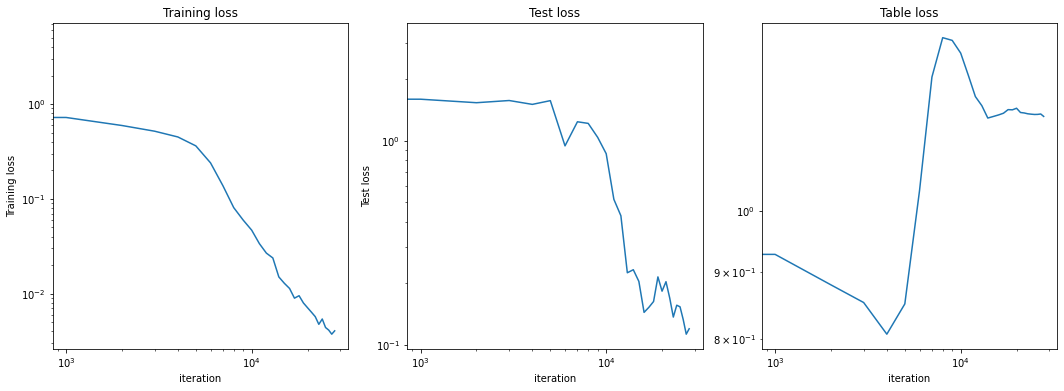

In [24]:
fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (18, 6))

ax = axs[0]
ax.plot(iterations,losses_tr)
ax.set_title('Training loss')
ax.set_xlabel('iteration')
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('Training loss')

ax = axs[1]
ax.set_title('Test loss')
ax.plot(iterations,losses_test)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')
ax.set_ylabel('Test loss')

ax = axs[2]
ax.set_title('Table loss')
ax.plot(iterations,losses_table)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('iteration')


In [25]:
# Get prediction as numpy array
x_pred = test_orbit["x_pred"]
#p_pred = test_orbit["p_pred"]
f_pred = test_orbit["f_pred"]

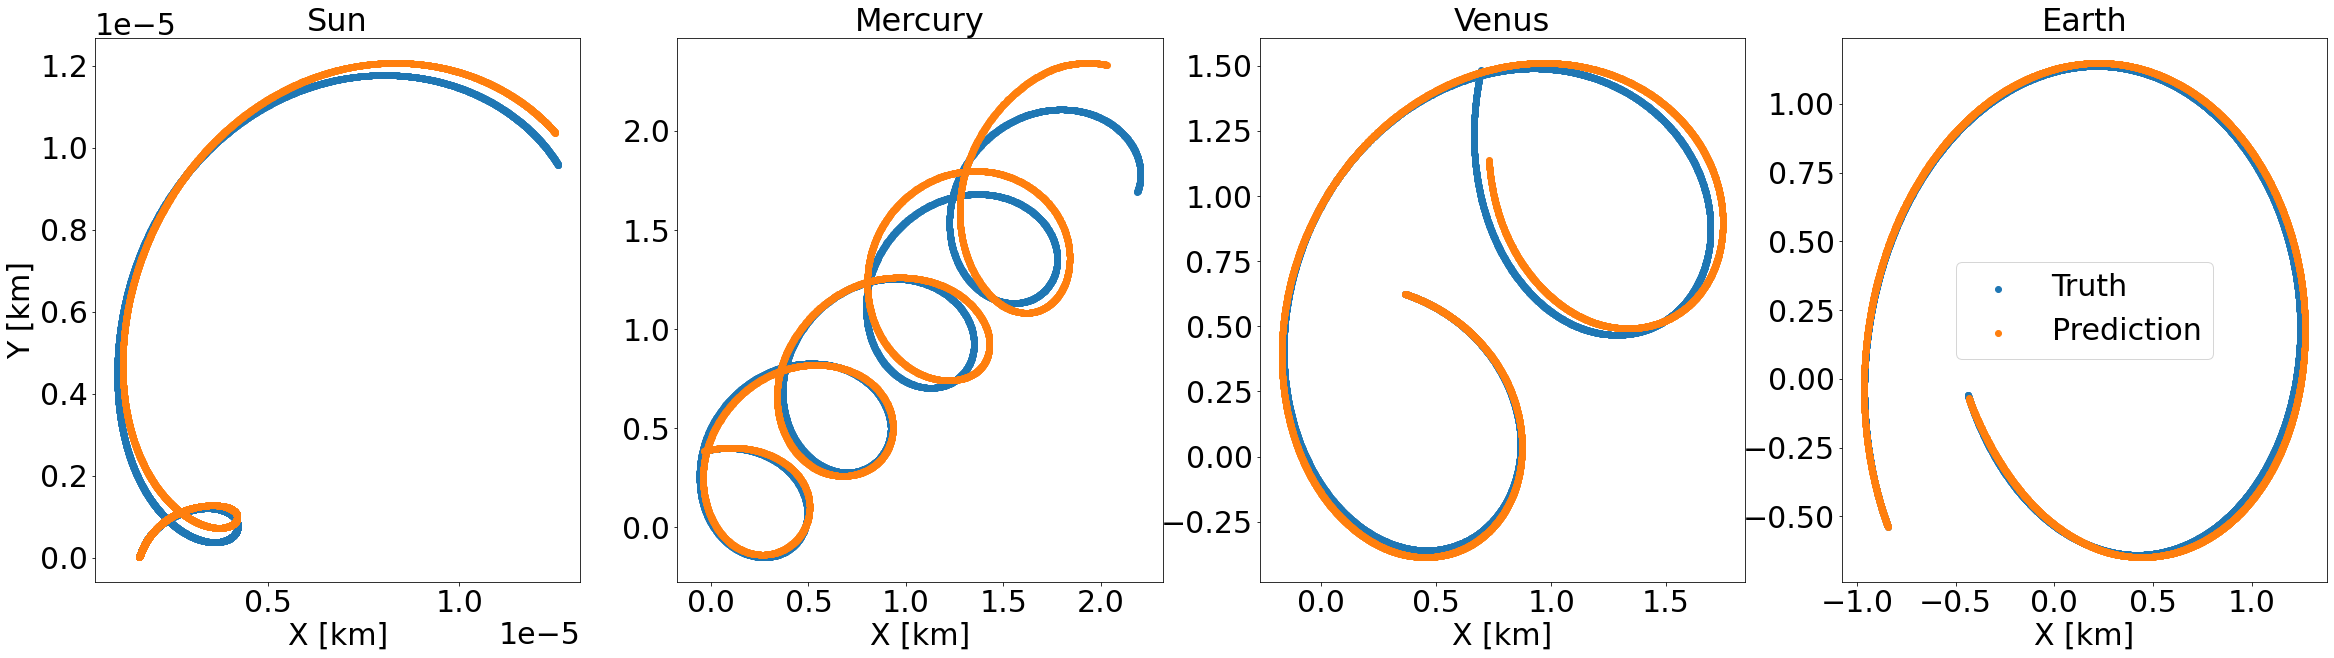

In [26]:
nsteps_plot = 365*12
plt.rcParams.update({'font.size': 30})
fig, axs =plt.subplots(nrows = 1, ncols = len(planets), figsize = (10*len(planets), 10))

periods = np.array([225, 88, 225, 1000, 1500])
factor = 10*periods

axs[0].set_ylabel('Y [km]')
for i in range(len(planets)):
    ax = axs[i]
    
    shift = x_traj_np[:,i,0].max()/factor[i]*np.arange(nsteps_plot)

    ax.set_title(planets[i].name, fontsize = 32)
    ax.scatter(x_traj_np[:nsteps_plot,i,0]+shift, x_traj_np[:nsteps_plot,i,1]+shift, label='Truth')
    ax.scatter(x_pred[:nsteps_plot,i,0]+shift, x_pred[:nsteps_plot,i,1]+shift, label='Prediction')
    ax.set_xlabel('X [km]')

plt.legend();
    
#plt.savefig('/Users/Pablo/Desktop/orbits')

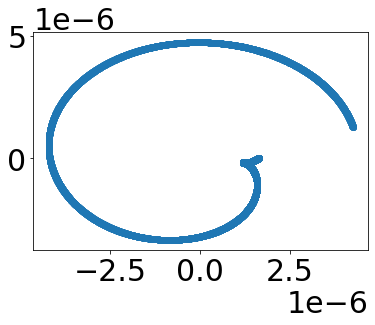

In [27]:
plt.scatter(x_traj_np[:nsteps_plot,0,0], x_traj_np[:nsteps_plot,0,1])

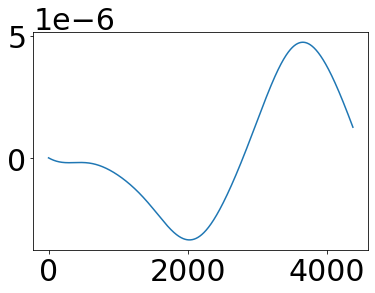

In [28]:
plt.plot(x_traj_np[:nsteps_plot,0,1])

In [29]:
nplanets = len(planets_gn)
nforce = len(f_pred[0])
order = [[0,1], [0,2], [1,2], [0,3], [1,3], [2,3]]
#order = [[0,1], [0,2], [1,2]]

masses_arr = np.zeros([nplanets, 1])
for i in range(nplanets):
    masses_arr[i] = planets_gn[i].mass

nsteps_table = 5000

table = np.zeros([nsteps_table*len(f_pred[0]), 7])
it = 0
for i in range(nsteps_table):
    x = x_pred[i]
    dx = get_distances_old(x, nplanets, as_tensor=False)
    ux = dx/np.linalg.norm(dx, axis = 1, keepdims=True)
    for j in range(nforce):
        ind = order[j]
        #print([planets[ind[0]].mass, planets[ind[1]].mass], dx[j], np.linalg.norm(dx[j]), f_pred[i, j])
        table[it] = np.concatenate([[planets[ind[0]].mass, planets[ind[1]].mass], ux[j], [np.linalg.norm(dx[j])], f_pred[i, j]/delta_time])
        it+=1
    
    #table[i] =  np.concatenate([masses_arr, dx, f_pred[i]], axis = 1)

IndexError: index 4382 is out of bounds for axis 0 with size 4382

In [ ]:
np.savetxt('/Users/Pablo/Desktop/orbits.txt', table)

In [ ]:
table

In [ ]:
np.linalg.norm([-0.9890098 ,  0.14784959])

In [ ]:
nplanets = len(planets_gn)
nforce = len(f_pred[0])
order = [[0,1], [0,2], [1,2], [0,3], [1,3], [2,3]]
#order = [[0,1], [0,2], [1,2]]

masses_arr = np.zeros([nplanets, 1])
for i in range(nplanets):
    masses_arr[i] = planets_gn[i].mass

nsteps_table = 4000

table = np.zeros([int(nsteps_table*len(f_pred[0])/2), 7])
it = 0
for i in range(nsteps_table):
    x = x_pred[i]
    dx = get_distances_old(x, nplanets, as_tensor=False)
    #ux = dx/np.linalg.norm(dx, axis = 1, keepdims=True)
    for j in range(nforce):
        if j in [0,1,3]: #Keep only interactions between sun and planets
            #All in units of solar mass, AU, year
            ind = order[j]
            table[it] = np.concatenate([[
                planets[ind[0]].mass, planets[ind[1]].mass], 
                dx[j], 
                [np.linalg.norm(dx[j])], 
                f_pred[i, j]/delta_time])
            it+=1

table = table[:it]


# DEBUG

In [ ]:
xpt = table_orbit["x_pred"]
ppt = table_orbit["dp_pred"]

In [ ]:
xtable_true = x_traj_table.eval(session=sess)
xtr_true = x_traj_tr.eval(session=sess)
dptable_true = dp_traj_table.eval(session=sess)

In [ ]:
xtable_true.shape

In [ ]:
i = 1
plt.scatter(xtr_true[i,:,0,0], xtr_true[i,:,0,1])
plt.scatter(xtr_true[i,:,1,0], xtr_true[i,:,1,1])

In [ ]:
i =0
#plt.scatter(xtable_true[i,:,0,0], xtable_true[i,:,0,1])
#plt.scatter(xtable_true[i,:,1,0], xtable_true[i,:,1,1])
plt.scatter(xpt[:,2*i+1, 0], xpt[:,2*i+1, 1])
plt.scatter(xpt[:,2*i, 0], xpt[:,2*i, 1])

In [ ]:
i =0
plt.scatter(dptable_true[i,:,0,0], dptable_true[i,:,0,1])
plt.scatter(dptable_true[i,:,1,0], dptable_true[i,:,1,1])
plt.scatter(ppt[:,2*i+1, 0], ppt[:,2*i+1, 1])

In [ ]:
i=0
plt.scatter(ppt[:,2*i, 0], ppt[:,2*i, 1])
plt.scatter(ppt[:,2*i+1, 0], ppt[:,2*i+1, 1])

In [ ]:
dpt_pred = dp_table.eval(session=sess)

In [ ]:
dpt_true = dp_traj_table.eval(session=sess)

In [ ]:
dpt_pred.shape

In [ ]:
dpt_true.shape

In [ ]:
i=0
plt.scatter(dpt_true[i,:,0,0], dpt_true[i,:,0,1])
plt.scatter(dpt_true[i,:,1,0], dpt_true[i,:,1,1])
plt.scatter(dpt_pred[:,2*i,0], dpt_pred[:,2*i,1])
plt.scatter(dpt_pred[:,2*i+1,0], dpt_pred[:,2*i+ 1,1])

In [ ]:
i=0
plt.scatter(dpt_pred[:,2*i,0], dpt_pred[:,2*i,1])
plt.scatter(dpt_pred[:,2*i+1,0], dpt_pred[:,2*i+ 1,1])

In [ ]:
x_pred.shape

In [ ]:
plt.scatter(f_pred[:,0,0], f_pred[:,0,1])
plt.scatter(f_pred[:,1,0], f_pred[:,1,1])
#plt.scatter(f_pred[:2000,2,0], f_pred[:2000,2,1])
plt.scatter(f_pred[:,3,0], f_pred[:,3,1])
#plt.scatter(f_pred[:2000,4,0], f_pred[:2000,4,1])
#plt.scatter(f_pred[:2000,5,0], f_pred[:2000,5,1])

In [ ]:
plt.scatter(f_pred[:2000,2,0], f_pred[:2000,2,1])
plt.scatter(f_pred[:2000,4,0], f_pred[:2000,4,1])
plt.scatter(f_pred[:2000,5,0], f_pred[:2000,5,1])

In [ ]:
plt.scatter(x_pred[:2000,0,0], x_pred[:2000,0,1])
plt.scatter(x_pred[:2000,1,0], x_pred[:2000,1,1])
plt.scatter(x_pred[:2000,2,0], x_pred[:2000,2,1])
plt.scatter(x_pred[:2000,3,0], x_pred[:2000,3,1])

In [ ]:
dp_traj_np.shape

In [ ]:
plt.scatter(dp_traj_np[:,0,0], dp_traj_np[:,0,1], label='Sun')
plt.scatter(dp_traj_np[:,1,0], dp_traj_np[:,1,1], label='Mercury')
plt.scatter(dp_traj_np[:,2,0], dp_traj_np[:,2,1], label='Venus')
plt.scatter(dp_traj_np[:,3,0], dp_traj_np[:,3,1], label='Earth')
#plt.legend()

In [ ]:
plt.scatter(p_traj_np[:2000,0,0], p_traj_np[:2000,0,1])
plt.scatter(p_traj_np[:2000,1,0], p_traj_np[:2000,1,1])
0plt.scatter(p_traj_np[:2000,2,0], p_traj_np[:2000,2,1])
plt.scatter(p_traj_np[:2000,3,0], p_traj_np[:2000,3,1])

In [ ]:
plt.scatter(p_traj_np[:,0,0], p_traj_np[:,0,1])

In [ ]:
dx = x_traj_np[:,2] - x_traj_np[:,0]
d = np.linalg.norm(dx, keepdims=True,axis=-1)
fvenus = G*venus.mass*sun.mass*dx/d**3*delta_time
plt.scatter(f_pred[:,3,0],f_pred[:,3,1])
plt.scatter(fvenus[:,0],fvenus[:,1])

In [ ]:
dx = x_traj_np[:,2] - x_traj_np[:,0]
d = np.linalg.norm(dx, keepdims=True,axis=-1)
fvenus = G*venus.mass*sun.mass*dx/d**3*delta_time
plt.scatter(f_pred[:,1,0],f_pred[:,1,1])
plt.scatter(fvenus[:,0],fvenus[:,1])

In [ ]:
dx = x_traj_np[:,1] - x_traj_np[:,0]
d = np.linalg.norm(dx, keepdims=True,axis=-1)
fmercury = G*mercury.mass*sun.mass*dx/d**3*delta_time
plt.scatter(f_pred[:,0,0],f_pred[:,0,1])
plt.scatter(fmercury[:,0],fmercury[:,1])

In [ ]:
dx = x_traj_np[:,3] - x_traj_np[:,0]
d = np.linalg.norm(dx, keepdims=True,axis=-1)
fearth = G*earth.mass*sun.mass*dx/d**3*delta_time
plt.scatter(f_pred[:,3,0],f_pred[:,3,1])
plt.scatter(fearth[:,0],fearth[:,1])